In [10]:
import os
import sys
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

PROJECT_PATH = os.path.abspath(os.path.join("..", ".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")

unflagged_data = False

if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)
    
from utils.paths import DESPIKED_DATA_DIRECTORY
from utils.config_files import load_json_config
from utils.import_data import import_acropolis_site_data
from config.sites_deloyment_times import deployment_times

assert(os.path.exists(DESPIKED_DATA_DIRECTORY))

# load files
config = load_json_config("config.json")

In [11]:
def plot_site_diurnal_patterns(site: str):
    """Plot diurnal patterns of CO₂ for a given site."""
    df = import_acropolis_site_data(target_directory=DESPIKED_DATA_DIRECTORY,
                                        deployment_times=deployment_times,
                                        site_name=site)
    # add datetime information
    spring = [3,4,5]
    summer = [6,7,8]
    fall = [9,10,11]
    winter = [12,1,2]

    df = df.with_columns(
        pl.col("datetime")
        .dt.convert_time_zone("Europe/Berlin")
        .alias("datetime_local")) \
        .with_columns(pl.col("datetime_local").dt.month().alias("month"),
                        pl.col("datetime_local").dt.weekday().alias("day_of_week"),
                        pl.col("datetime_local").dt.hour().alias("hour_of_day")) \
        .with_columns(
            pl.when(pl.col("month").is_in(spring)).then(pl.lit("spring"))
            .when(pl.col("month").is_in(summer)).then(pl.lit("summer"))
            .when(pl.col("month").is_in(fall)).then(pl.lit("fall"))
            .when(pl.col("month").is_in(winter)).then(pl.lit("winter"))
            .otherwise(None)
            .alias("season")
        ).sort("hour_of_day")

    df_summer = df.filter(pl.col("season") == "summer") \
        .group_by("hour_of_day") \
        .agg(pl.col("gmp343_corrected").mean().alias("mean_co2_summer"),
             pl.col("gmp343_corrected").quantile(0.05).alias("q05_co2"),
             pl.col("gmp343_corrected").quantile(0.95).alias("q95_co2"),
             pl.col("gmp343_corrected").std().alias("std_co2_summer"),
             pl.count("gmp343_corrected").alias("n_summer"))

    df_fall = df.filter(pl.col("season") == "fall") \
        .group_by("hour_of_day") \
        .agg(pl.col("gmp343_corrected").mean().alias("mean_co2_fall"),
             pl.col("gmp343_corrected").quantile(0.05).alias("q05_co2"),
             pl.col("gmp343_corrected").quantile(0.95).alias("q95_co2"),
             pl.col("gmp343_corrected").std().alias("std_co2_fall"),
             pl.count("gmp343_corrected").alias("n_fall"))

    df_winter = df.filter(pl.col("season") == "winter") \
        .group_by("hour_of_day") \
        .agg(pl.col("gmp343_corrected").mean().alias("mean_co2_winter"),
             pl.col("gmp343_corrected").quantile(0.05).alias("q05_co2"),
             pl.col("gmp343_corrected").quantile(0.95).alias("q95_co2"),
             pl.col("gmp343_corrected").std().alias("std_co2_winter"),
             pl.count("gmp343_corrected").alias("n_winter"))

    df_spring = df.filter(pl.col("season") == "spring") \
        .group_by("hour_of_day") \
        .agg(pl.col("gmp343_corrected").mean().alias("mean_co2_spring"),
             pl.col("gmp343_corrected").quantile(0.05).alias("q05_co2"),
             pl.col("gmp343_corrected").quantile(0.95).alias("q95_co2"),
             pl.col("gmp343_corrected").std().alias("std_co2_spring"),
             pl.count("gmp343_corrected").alias("n_spring"))
        
    y_summer = df_summer["mean_co2_summer"].to_numpy()
    y_fall = df_fall["mean_co2_fall"].to_numpy()
    y_winter = df_winter["mean_co2_winter"].to_numpy()
    y_spring = df_spring["mean_co2_spring"].to_numpy()

    plt.figure(figsize=(12, 5))

    if len(y_spring) > 0:
        x_values = df_spring["hour_of_day"].to_numpy()
        std = df_spring["std_co2_spring"].to_numpy()
        n = df_spring["n_spring"].to_numpy()
        ci = 1.96 * std / np.sqrt(n)
        plt.plot(x_values, y_spring, label="Spring", color="tab:green", alpha=0.9, linewidth=1.5)
        plt.fill_between(x_values, y_spring - ci, y_spring + ci, color="tab:green", alpha=0.2)

    if len(y_summer) > 0:
        x_values = df_summer["hour_of_day"].to_numpy()
        std = df_summer["std_co2_summer"].to_numpy()
        n = df_summer["n_summer"].to_numpy()
        ci = 1.96 * std / np.sqrt(n)
        plt.plot(x_values, y_summer, label="Summer", color="tab:orange", alpha=0.9, linewidth=1.5)
        plt.fill_between(x_values, y_summer - ci, y_summer + ci, color="tab:orange", alpha=0.2)

    if len(y_fall) > 0:
        x_values = df_fall["hour_of_day"].to_numpy()
        std = df_fall["std_co2_fall"].to_numpy()
        n = df_fall["n_fall"].to_numpy()
        ci = 1.96 * std / np.sqrt(n)
        plt.plot(x_values, y_fall, label="Fall", color="tab:red", alpha=0.9, linewidth=1.5)
        plt.fill_between(x_values, y_fall - ci, y_fall + ci, color="tab:red", alpha=0.2)

    if len(y_winter) > 0:
        x_values = df_winter["hour_of_day"].to_numpy()
        std = df_winter["std_co2_winter"].to_numpy()
        n = df_winter["n_winter"].to_numpy()
        ci = 1.96 * std / np.sqrt(n)
        plt.plot(x_values, y_winter, label="Winter", color="tab:blue", alpha=0.9, linewidth=1.5)
        plt.fill_between(x_values, y_winter - ci, y_winter + ci, color="tab:blue", alpha=0.2)

    plt.xlabel("Hour of Day (Local Time: CET/CEST)")
    plt.ylabel("Mean CO₂ (ppm)")
    plt.title(f"{site}: Diurnal CO₂ Patterns by Season")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

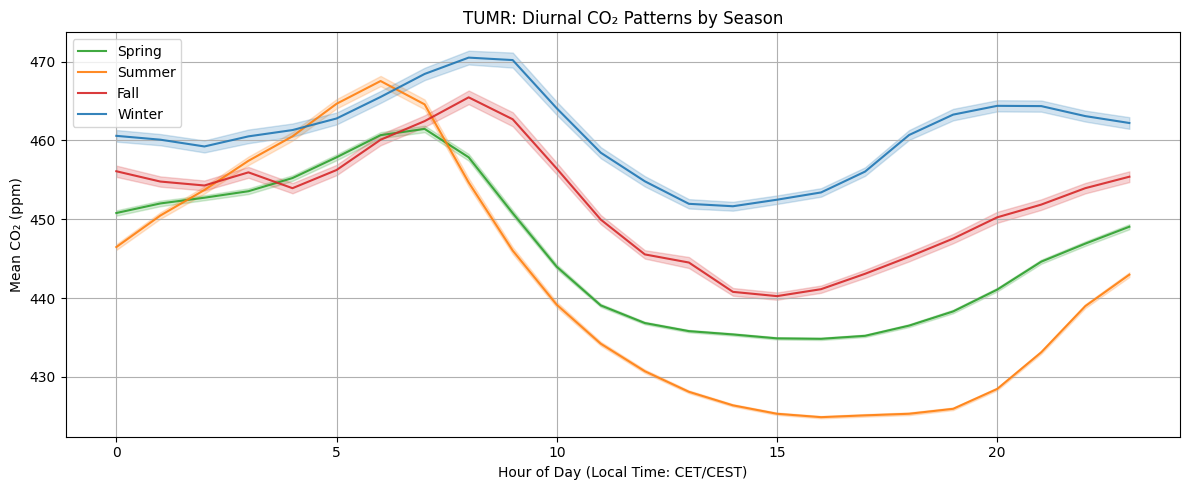

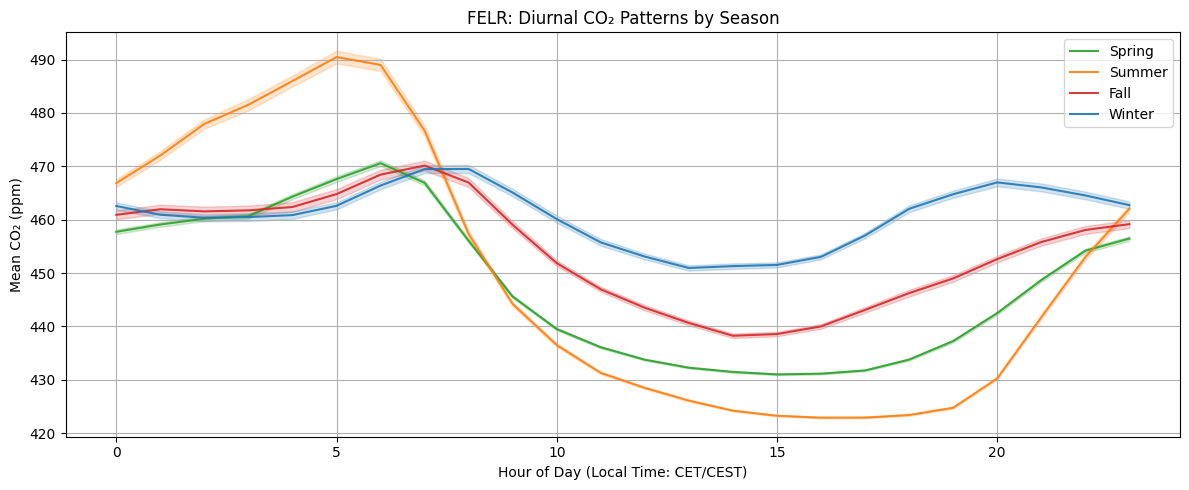

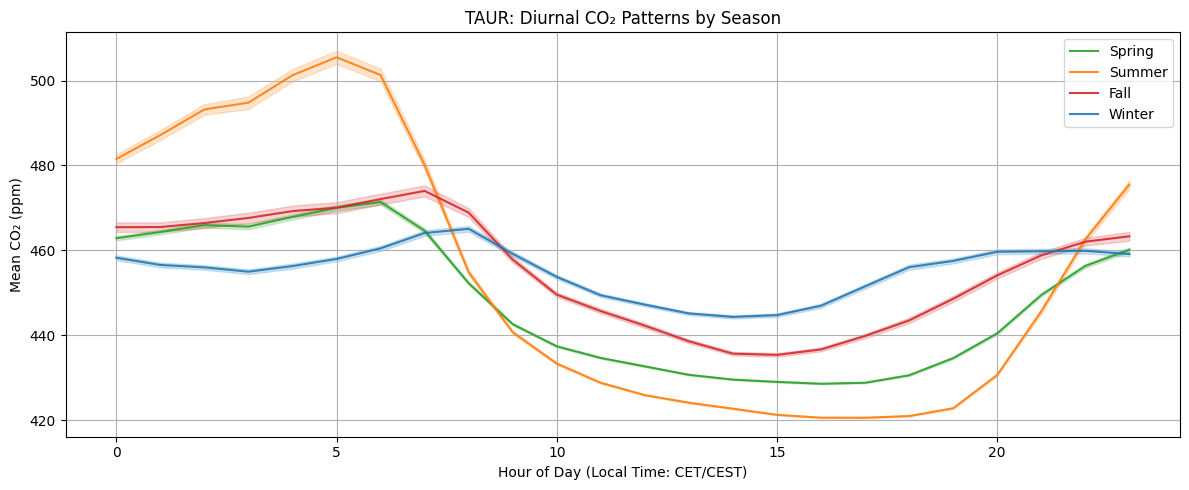

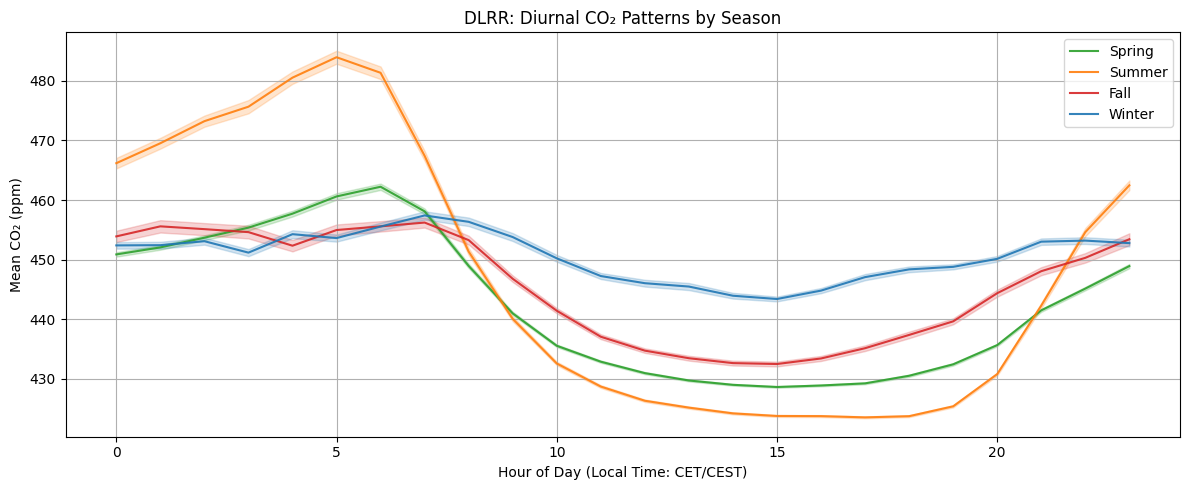

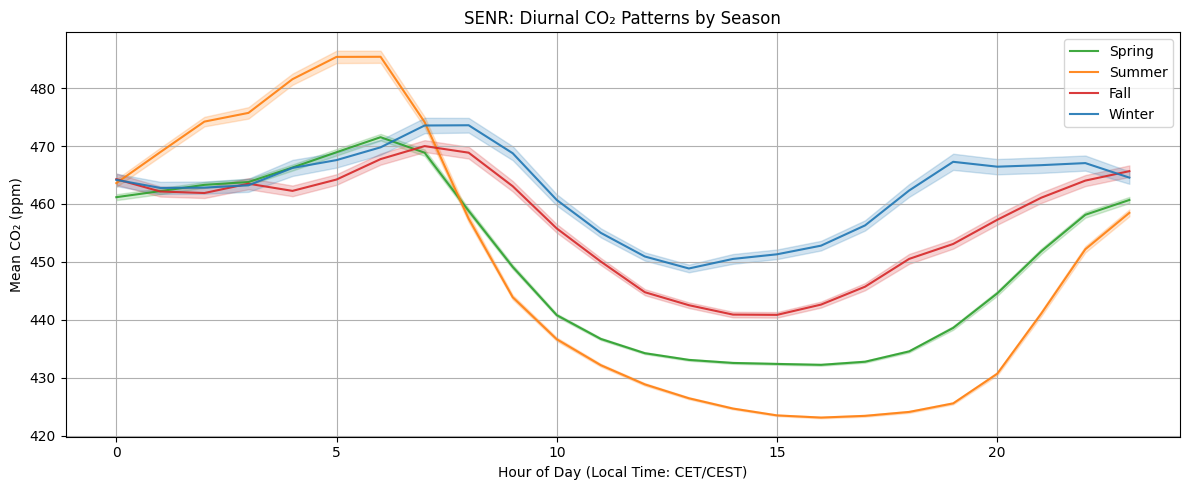

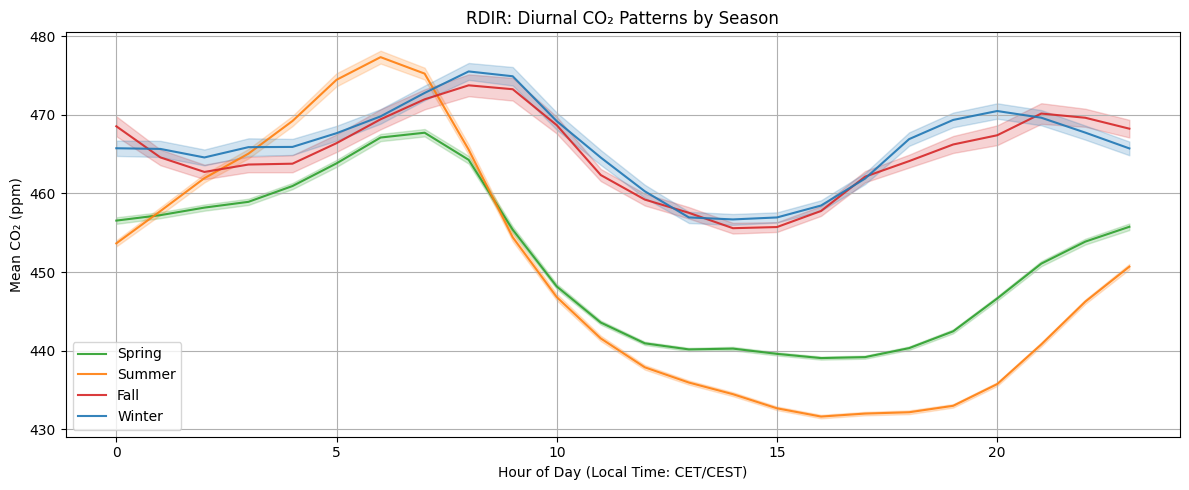

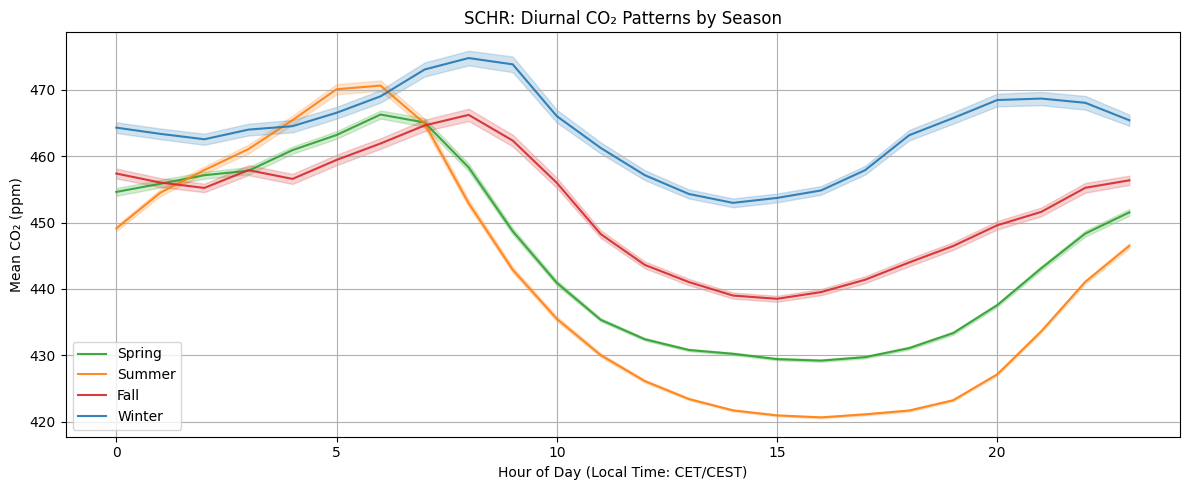

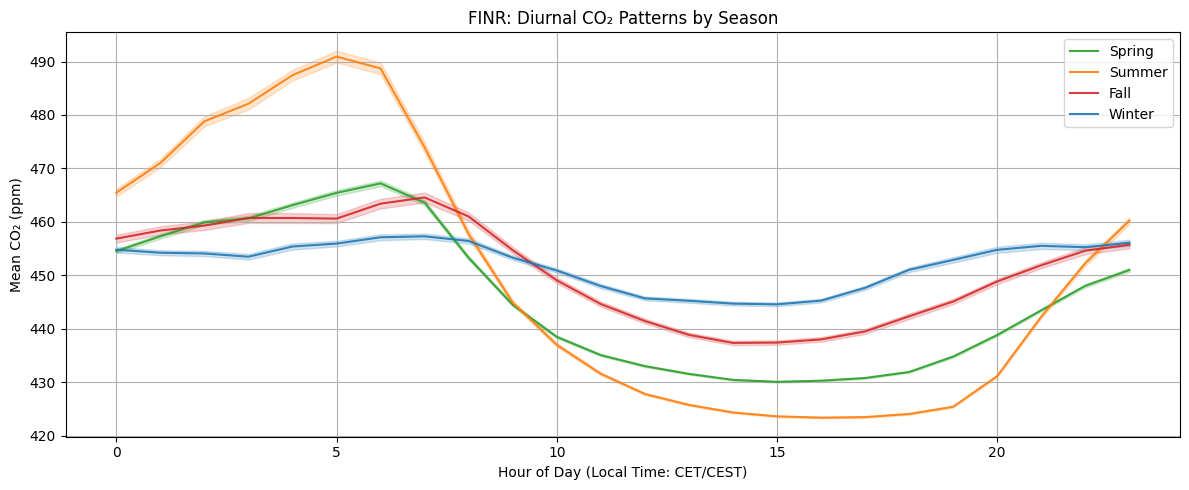

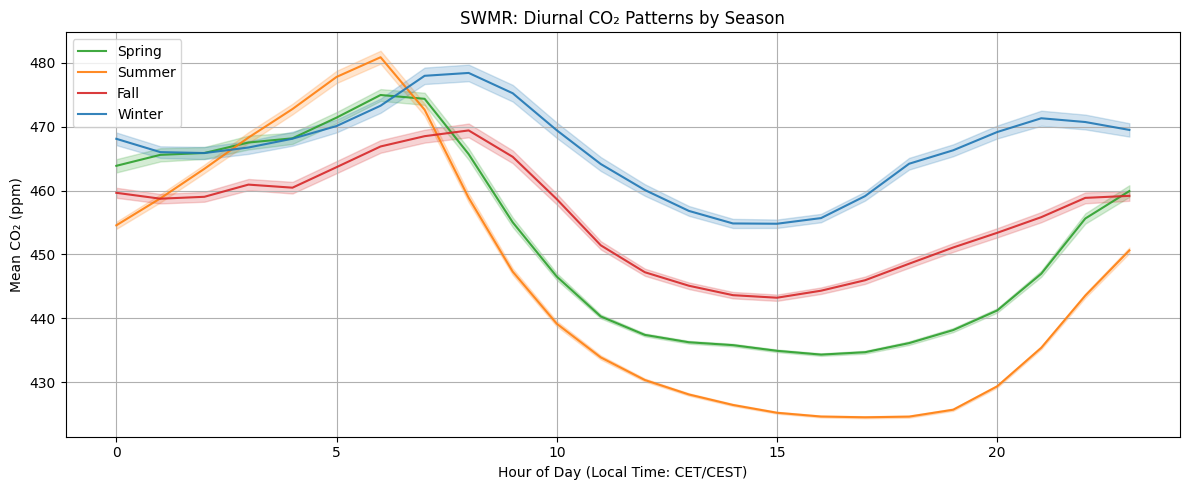

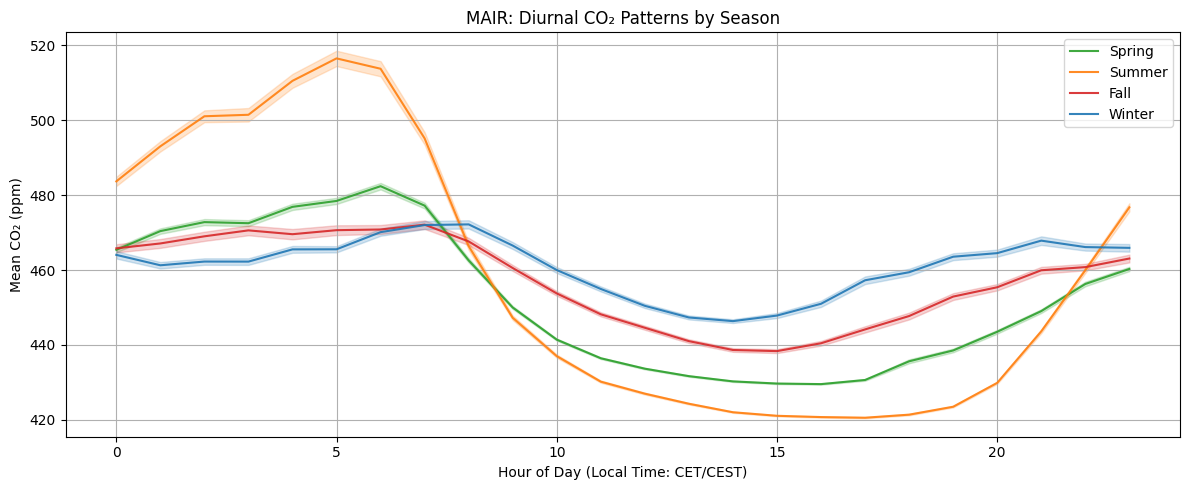

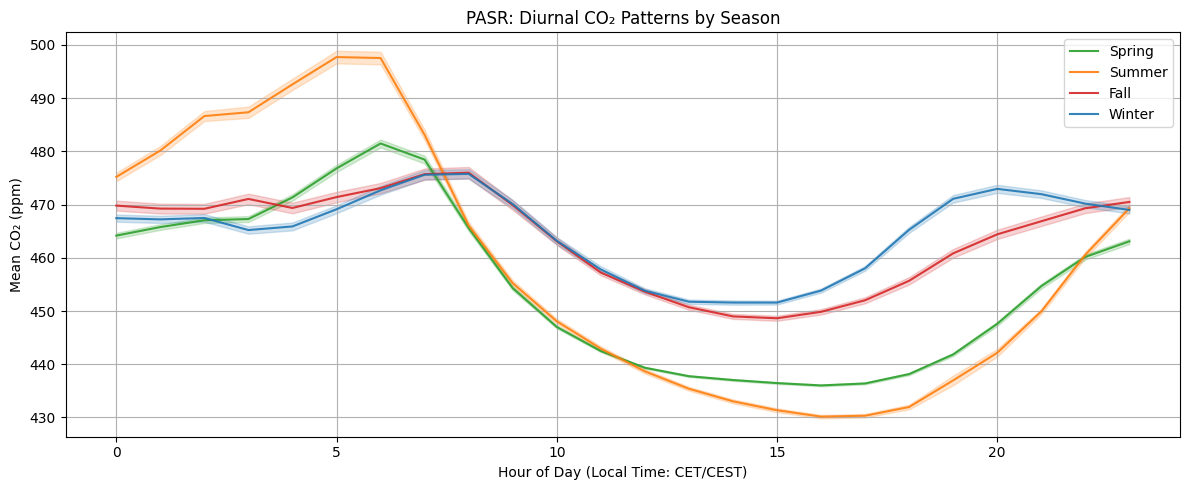

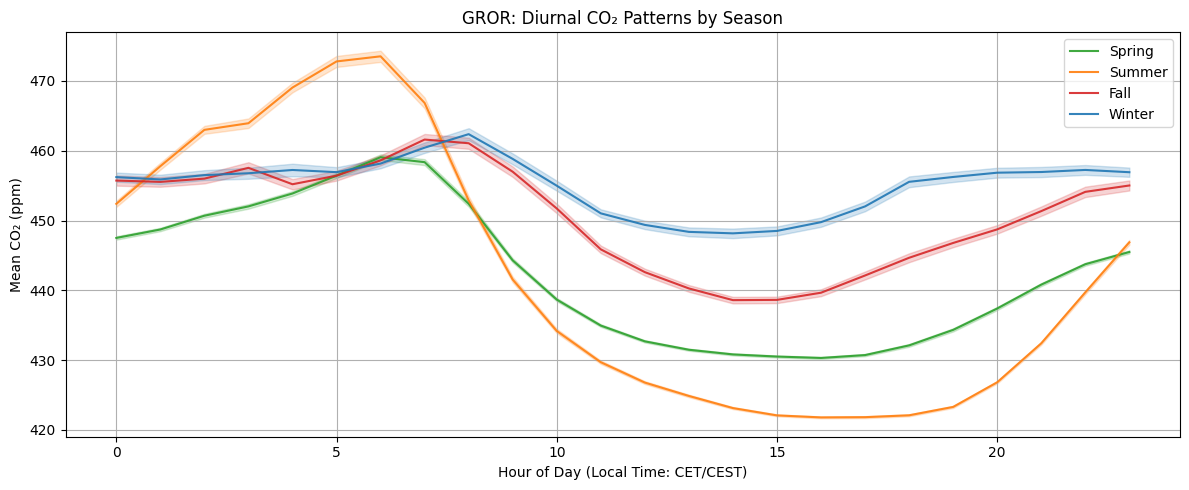

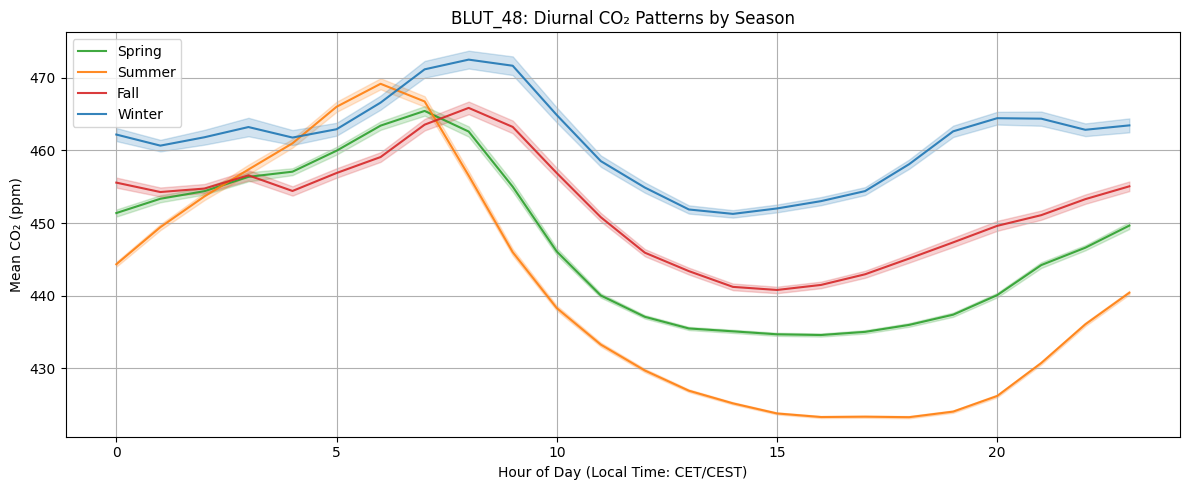

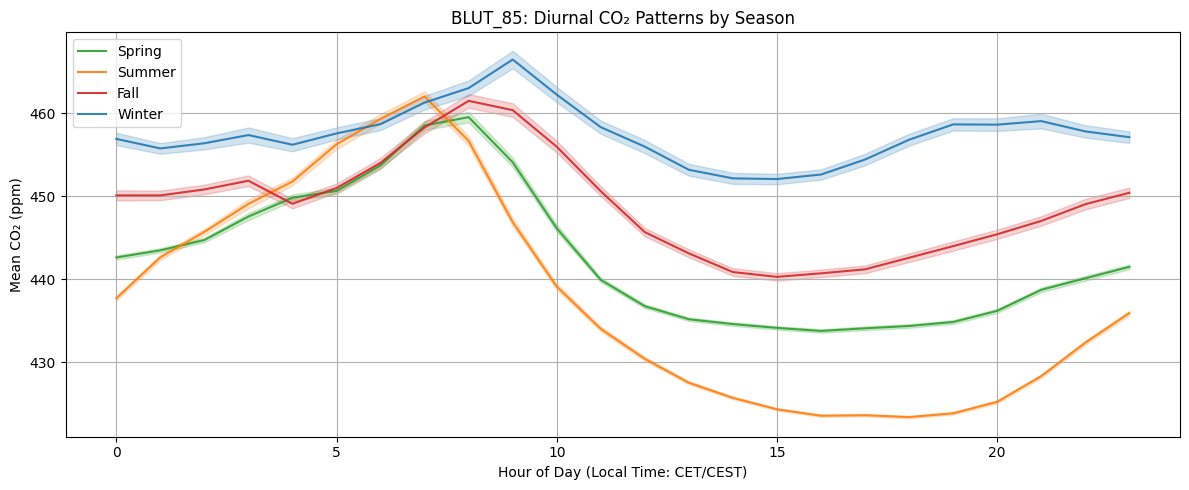

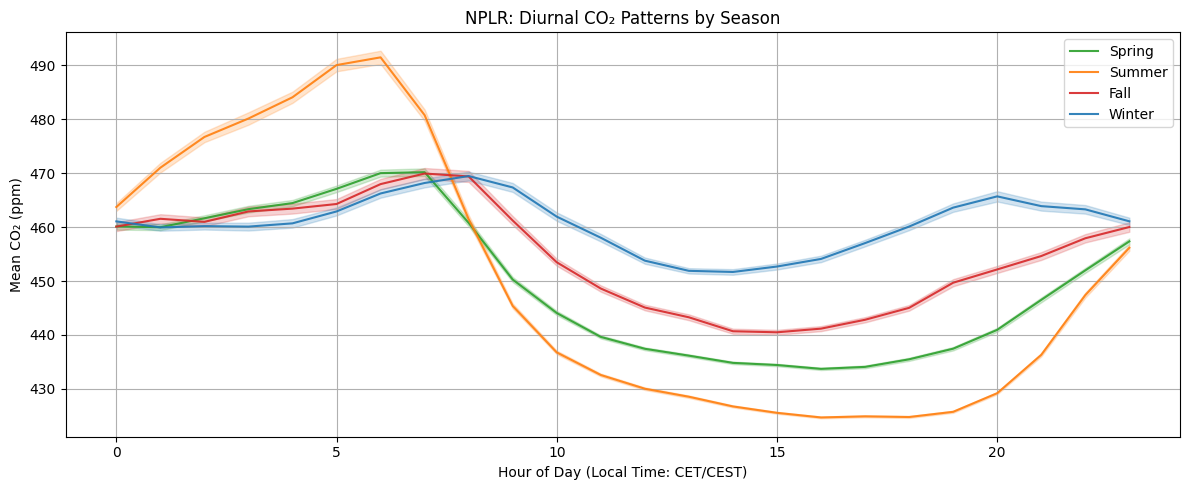

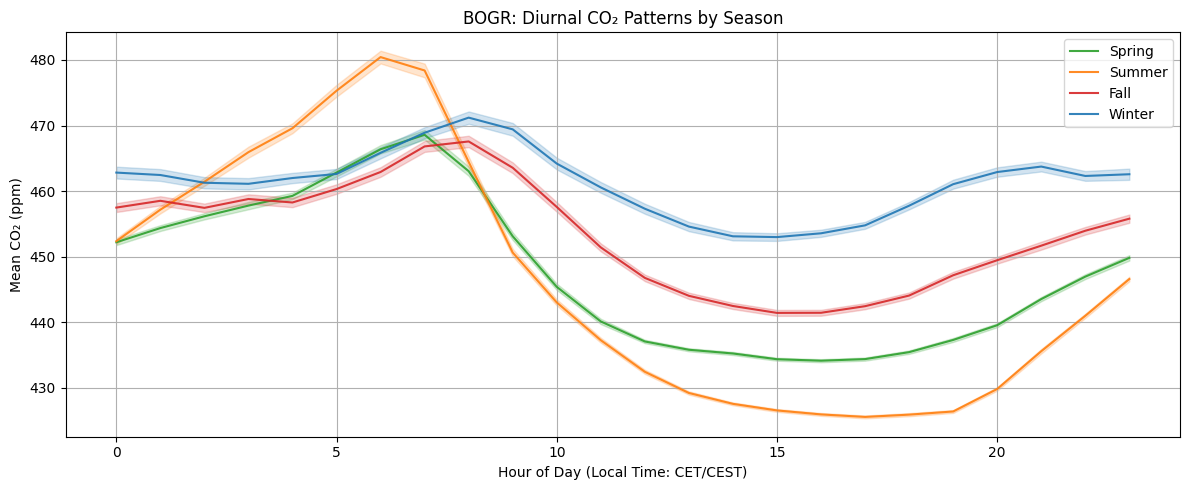

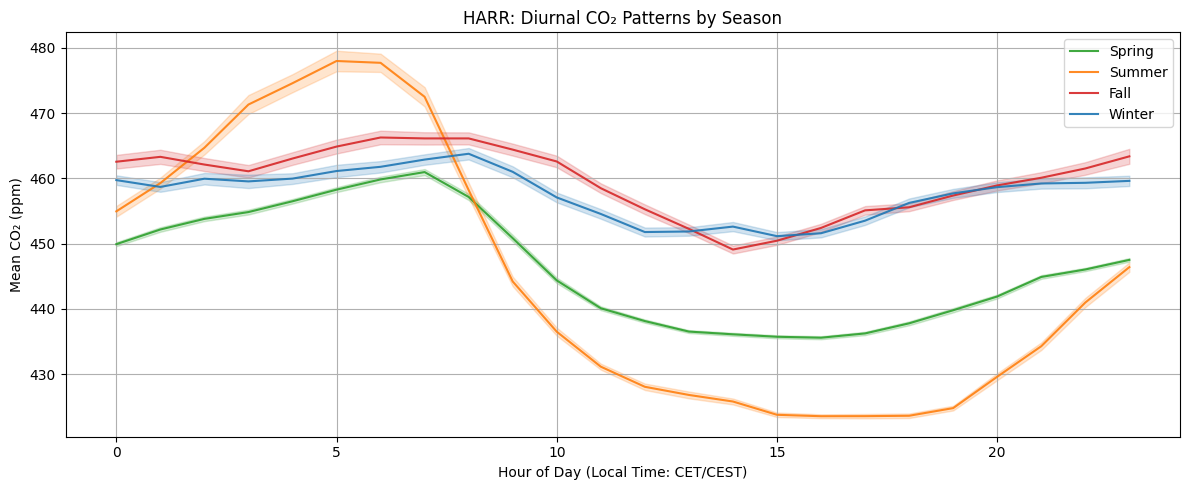

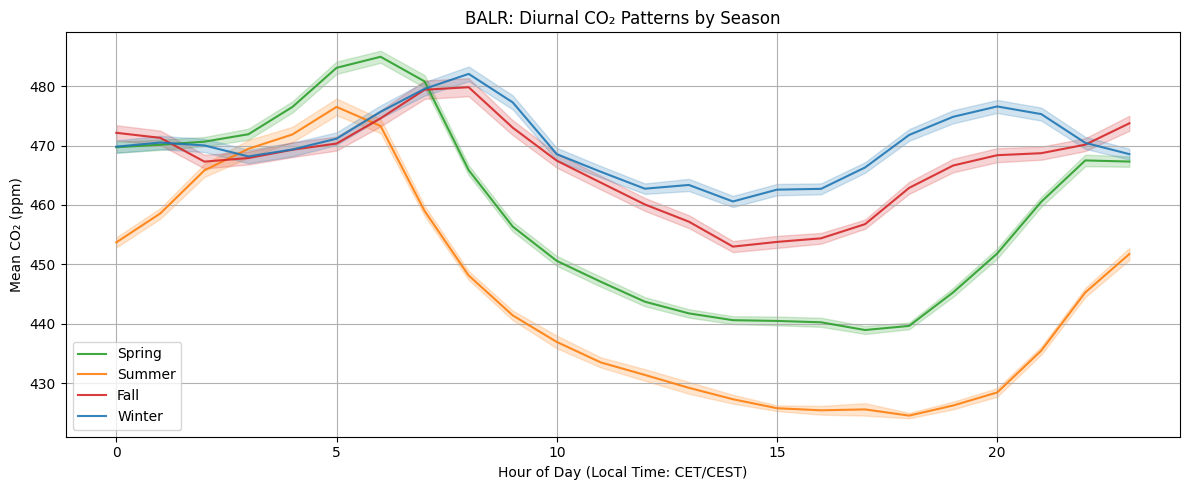

In [12]:
for site in config["icos_cities_portal"]["site_names"]:
    plot_site_diurnal_patterns(site)

In [13]:
def plot_site_diurnal_patterns_all_sites():
    """Plot diurnal patterns of CO₂ for all sites in a 3x6 grid."""
    
    site_names = config["icos_cities_portal"]["site_names"]
    num_sites = len(site_names)
    num_rows, num_cols = 6, 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15), sharex=True, sharey=True)
    axes = axes.flatten()  # Make indexing easier

    for i, site in enumerate(site_names):
        ax = axes[i]
        
        df = import_acropolis_site_data(
            target_directory=DESPIKED_DATA_DIRECTORY,
            deployment_times=deployment_times,
            site_name=site
        )

        # add datetime information
        spring = [3,4,5]
        summer = [6,7,8]
        fall = [9,10,11]
        winter = [12,1,2]

        df = df.with_columns(
            pl.col("datetime").dt.convert_time_zone("Europe/Berlin").alias("datetime_local")
        ).with_columns([
            pl.col("datetime_local").dt.month().alias("month"),
            pl.col("datetime_local").dt.weekday().alias("day_of_week"),
            pl.col("datetime_local").dt.hour().alias("hour_of_day")
        ]).with_columns(
            pl.when(pl.col("month").is_in(spring)).then(pl.lit("spring"))
            .when(pl.col("month").is_in(summer)).then(pl.lit("summer"))
            .when(pl.col("month").is_in(fall)).then(pl.lit("fall"))
            .when(pl.col("month").is_in(winter)).then(pl.lit("winter"))
            .otherwise(None).alias("season")
        ).sort("hour_of_day")

        def seasonal_stats(season, label):
            return df.filter(pl.col("season") == season) \
                .group_by("hour_of_day") \
                .agg([
                    pl.col("gmp343_corrected").mean().alias(f"mean_co2_{label}"),
                    pl.col("gmp343_corrected").std().alias(f"std_co2_{label}"),
                    pl.len().alias(f"n_{label}")
                ])
        
        df_seasonal = {
            "spring": seasonal_stats("spring", "spring"),
            "summer": seasonal_stats("summer", "summer"),
            "fall": seasonal_stats("fall", "fall"),
            "winter": seasonal_stats("winter", "winter")
        }

        colors = {
            "spring": "tab:green",
            "summer": "tab:orange",
            "fall": "tab:red",
            "winter": "tab:blue"
        }

        for season, df_season in df_seasonal.items():
            if df_season.height == 0:
                continue
            x = df_season["hour_of_day"].to_numpy()
            y = df_season[f"mean_co2_{season}"].to_numpy()
            std = df_season[f"std_co2_{season}"].to_numpy()
            n = df_season[f"n_{season}"].to_numpy()
            ci = 1.96 * std / np.sqrt(n)

            ax.plot(x, y, label=season.capitalize(), color=colors[season], alpha=0.9, linewidth=1.5)
            ax.fill_between(x, y - ci, y + ci, color=colors[season], alpha=0.2)

        ax.set_title(site)
        ax.grid(True)
        if i % num_cols == 0:
            ax.set_ylabel("CO₂ (ppm)")
        if i >= num_sites - num_cols:
            ax.set_xlabel("Hour of Day (Local Time: CET/CEST)")

    # Hide unused subplots if < 20 sites
    for j in range(len(site_names), len(axes)):
        fig.delaxes(axes[j])

    # Collect unique legend entries from all subplots
    all_handles = []
    all_labels = []

    for ax in axes[:num_sites]:  # Only active axes
        handles, labels = ax.get_legend_handles_labels()
        for h, l in zip(handles, labels):
            if l not in all_labels:
                all_handles.append(h)
                all_labels.append(l)

    fig.legend(all_handles, all_labels, 
               loc="lower center", 
               bbox_to_anchor=(0.5, -0.02),
                ncol=4,
                frameon=False,
                fontsize=14,)
    #fig.suptitle("Diurnal CO₂ Patterns by Season for All Sites", fontsize=16)
    fig.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

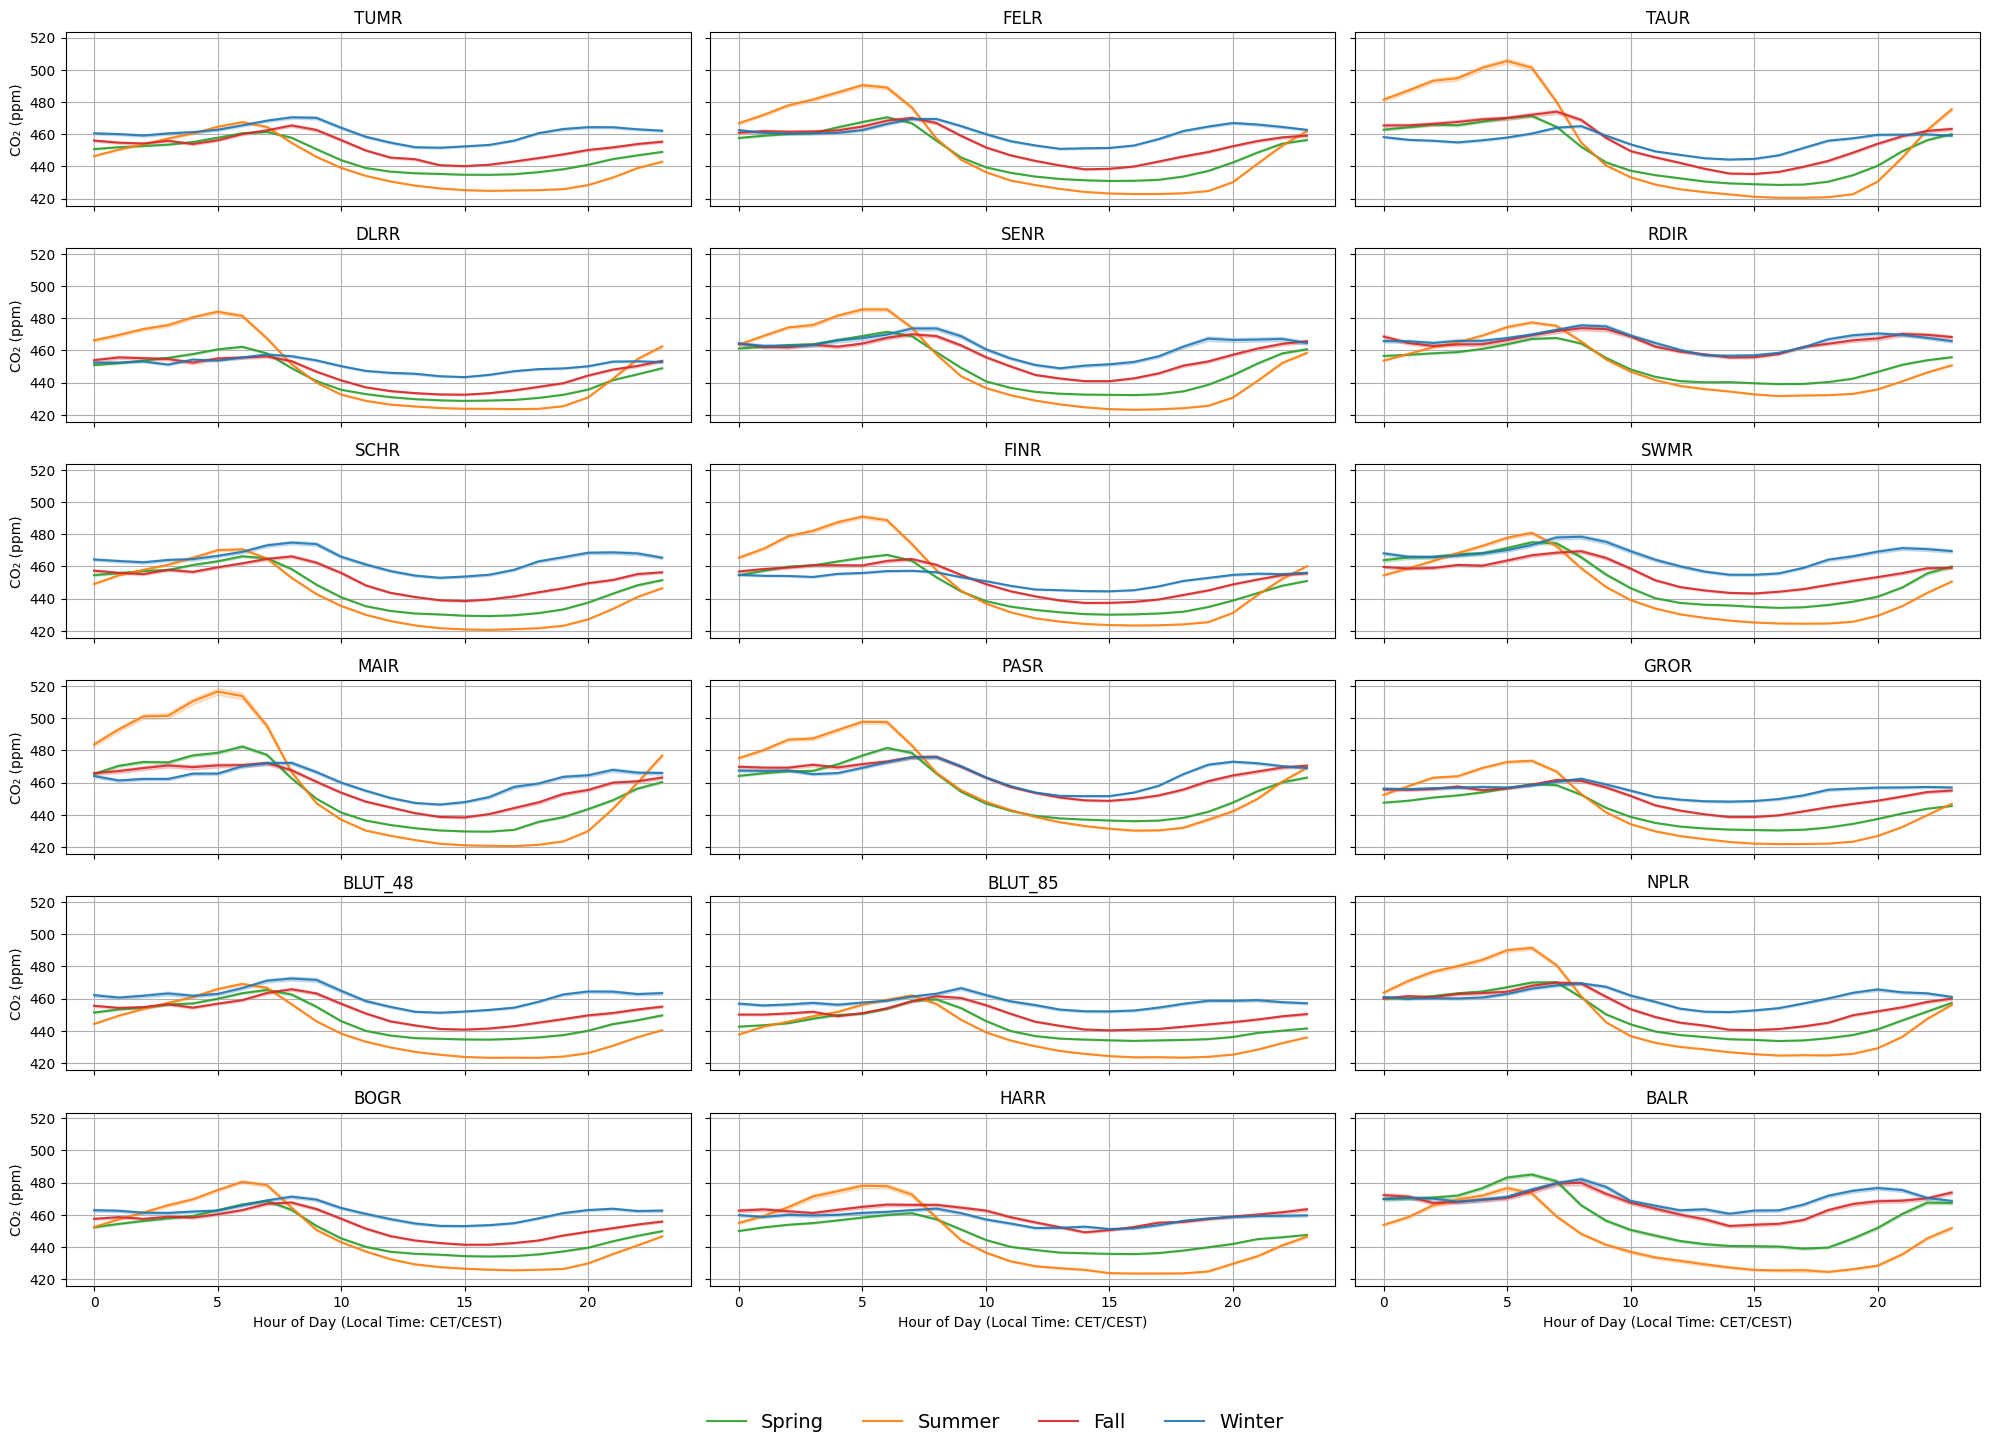

In [14]:
plot_site_diurnal_patterns_all_sites()

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

def plot_diurnal_patterns_by_season(selected_sites):
    """
    Plot hourly diurnal CO₂ patterns for the four main seasons.
    Layout: 1 row, 4 columns (Spring - Summer - Fall - Winter).
    Each subplot shows one curve per site.
    
    Parameters
    ----------
    selected_sites : list[str]
        Exactly four site names/IDs (order = legend order).
    """
    # ----- basic checks & plotting set-up -----
    #assert len(selected_sites) == 4, "Provide exactly four site IDs."

    season_order = ["spring", "summer", "fall", "winter"]
    season_months = {
        "spring": [3, 4, 5],
        "summer": [6, 7, 8],
        "fall"  : [9, 10, 11],
        "winter": [12, 1, 2]
    }

    # give every site its own colour (matplotlib tab10 works nicely for ≤10 lines)
    site_colors = {
        site: plt.cm.tab10(i) for i, site in enumerate(selected_sites)
    }

    # ----- load & pre-compute hourly stats for every site -----
    stats = {site: {} for site in selected_sites}  # nested dict [site][season] -> df

    for site in selected_sites:
        df = import_acropolis_site_data(
            target_directory=DESPIKED_DATA_DIRECTORY,
            deployment_times=deployment_times,
            site_name=site
        ).with_columns(
                pl.col("datetime")
                  .dt.convert_time_zone("Europe/Berlin")
                  .alias("datetime_local")
            ) \
            .with_columns([
                pl.col("datetime_local").dt.month().alias("month"),
                pl.col("datetime_local").dt.hour().alias("hour_of_day")
            ]) \
            .with_columns(
                pl.when(pl.col("month").is_in(season_months["spring"])).then(pl.lit("spring"))
                .when(pl.col("month").is_in(season_months["summer"])).then(pl.lit("summer"))
                .when(pl.col("month").is_in(season_months["fall"]  )).then(pl.lit("fall"))
                .when(pl.col("month").is_in(season_months["winter"])).then(pl.lit("winter"))
                .otherwise(None).alias("season")
            ) \
            .group_by(["season", "hour_of_day"]) \
              .agg([
                  pl.col("gmp343_corrected").mean().alias("mean"),
                  pl.col("gmp343_corrected").std().alias("std"),
                  pl.len().alias("n")
              ]) \
        .sort("hour_of_day")

        # split into season-specific frames for easier plotting
        for s in season_order:
            stats[site][s] = df.filter(pl.col("season") == s)

    # ----- plotting -----
    fig, axes = plt.subplots(1, 4, figsize=(24, 5), sharex=True, sharey=True)

    for j, season in enumerate(season_order):
        ax = axes[j]

        for site in selected_sites:
            df_season = stats[site][season]
            if df_season.height == 0:        # skip missing data
                continue

            x   = df_season["hour_of_day"].to_numpy()
            y   = df_season["mean"].to_numpy()
            std = df_season["std"].to_numpy()
            n   = df_season["n"].to_numpy()
            ci  = 1.96 * std / np.sqrt(n)

            ax.plot(
                x, y,
                label=site,
                color=site_colors[site],
                linewidth=1.6
            )
            ax.fill_between(
                x, y - ci, y + ci,
                color=site_colors[site],
                alpha=0.2
            )

        ax.set_title(season.capitalize())
        ax.grid(True, linewidth=0.3, alpha=0.6)
        ax.set_xlim(0, 23)
        if j == 0:
            ax.set_ylabel("Hourly Aggregated CO₂ (ppm)")
        ax.set_xlabel("Hour of Day (Local Time: CET/CEST)")

    # one common legend (sites) centred underneath the plots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.12),
        ncol=len(selected_sites),
        frameon=False,
        fontsize=13
    )
    fig.tight_layout(rect=[0, 0.03, 1, 0.92])
    plt.show()

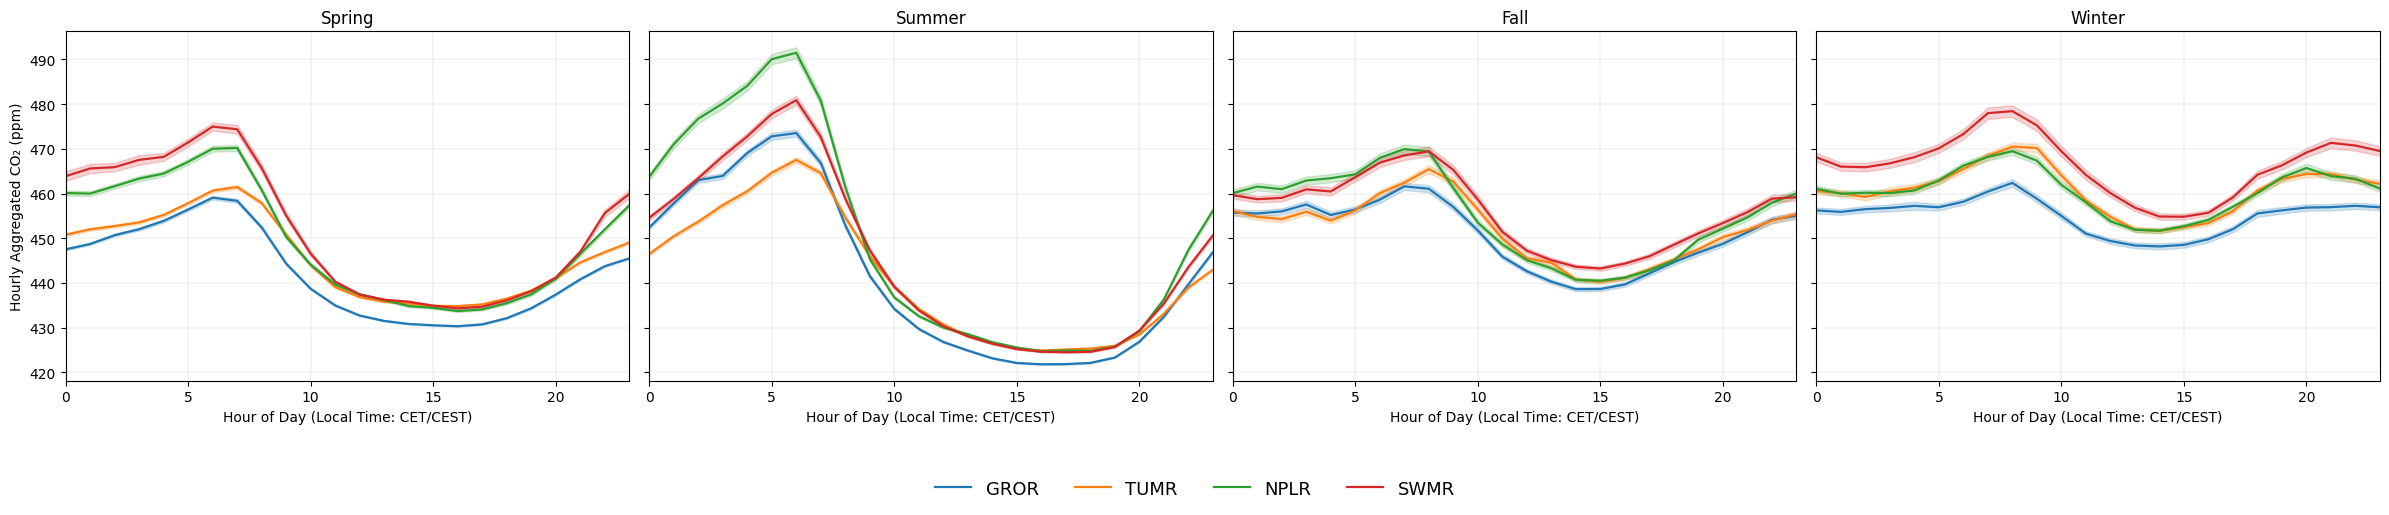

In [16]:
sites = ["GROR", "TUMR", "NPLR", "SWMR"] 
plot_diurnal_patterns_by_season(sites)